In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

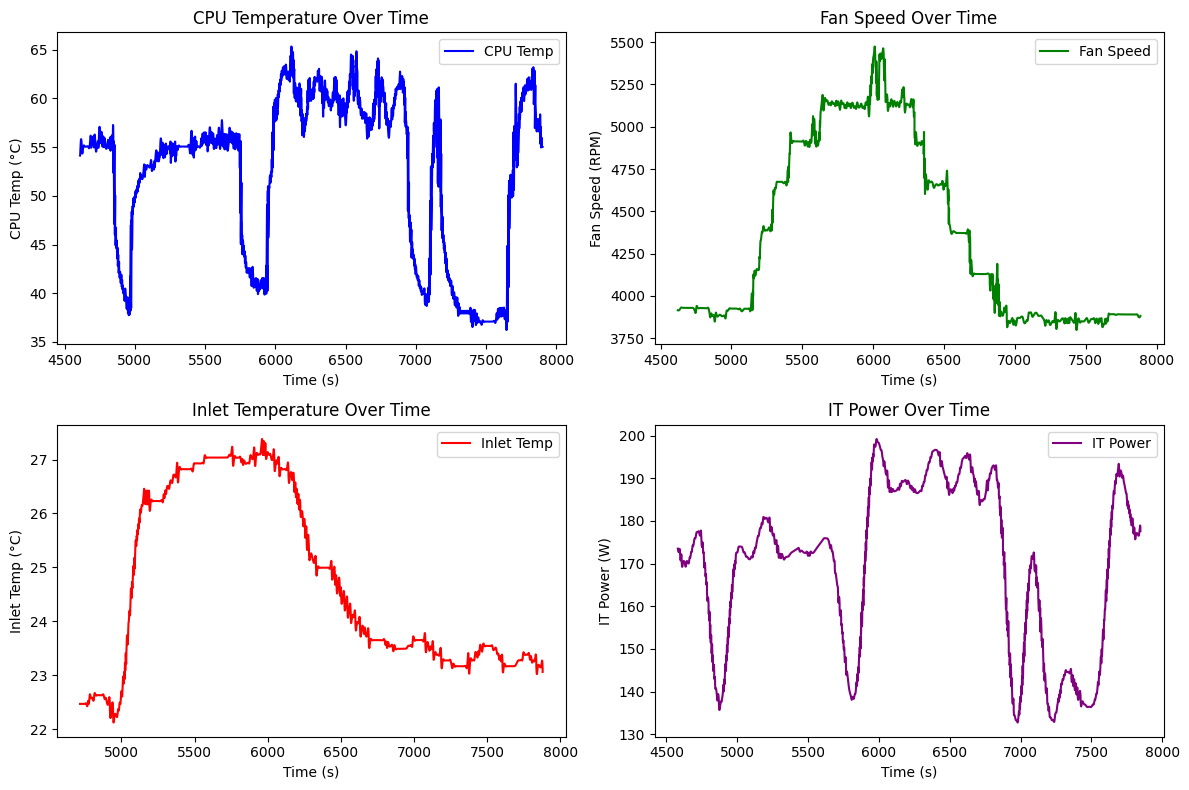

Shape of Final Dataframe = (4255, 5)


In [31]:
cpu_temp = pd.read_csv("../data/cpu-temp.csv", header=None, names=["time", "cpu_temp"])
fan_speed = pd.read_csv("../data/fan-speed.csv", header=None, names=["time", "fan_speed"])
inlet_temp = pd.read_csv("../data/inlet-temp.csv", header=None, names=["time", "inlet_temp"])
it_power = pd.read_csv("../data/it-power.csv", header=None, names=["time", "it_power"])

def process_dataframe(df, time_col, value_col):
    df[time_col] = df[time_col].astype(int)

    min_time = df[time_col].min()
    max_time = df[time_col].max()
    full_index = pd.DataFrame({time_col: np.arange(min_time, max_time + 1)})

    df_full = pd.merge(full_index, df, on=time_col, how='left')
    df_full[value_col] = df_full[value_col].interpolate(method="polynomial", order=2)

    return df_full

cpu_temp_new = process_dataframe(cpu_temp, "time", "cpu_temp")
fan_speed_new = process_dataframe(fan_speed, "time", "fan_speed")
inlet_temp_new = process_dataframe(inlet_temp, "time", "inlet_temp")
it_power_new = process_dataframe(it_power, "time", "it_power")

def plot_time_series_subplots(cpu_temp_df, fan_speed_df, inlet_temp_df, it_power_df, time_col):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # First subplot - CPU Temperature
    axs[0, 0].plot(cpu_temp_df[time_col], cpu_temp_df['cpu_temp'], color='blue', label='CPU Temp')
    axs[0, 0].set_title('CPU Temperature Over Time')
    axs[0, 0].set_xlabel('Time (s)')
    axs[0, 0].set_ylabel('CPU Temp (°C)')
    axs[0, 0].legend()

    # Second subplot - Fan Speed
    axs[0, 1].plot(fan_speed_df[time_col], fan_speed_df['fan_speed'], color='green', label='Fan Speed')
    axs[0, 1].set_title('Fan Speed Over Time')
    axs[0, 1].set_xlabel('Time (s)')
    axs[0, 1].set_ylabel('Fan Speed (RPM)')
    axs[0, 1].legend()

    # Third subplot - Inlet Temperature
    axs[1, 0].plot(inlet_temp_df[time_col], inlet_temp_df['inlet_temp'], color='red', label='Inlet Temp')
    axs[1, 0].set_title('Inlet Temperature Over Time')
    axs[1, 0].set_xlabel('Time (s)')
    axs[1, 0].set_ylabel('Inlet Temp (°C)')
    axs[1, 0].legend()

    # Fourth subplot - IT Power
    axs[1, 1].plot(it_power_df[time_col], it_power_df['it_power'], color='purple', label='IT Power')
    axs[1, 1].set_title('IT Power Over Time')
    axs[1, 1].set_xlabel('Time (s)')
    axs[1, 1].set_ylabel('IT Power (W)')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()


plot_time_series_subplots(cpu_temp_new, fan_speed_new, inlet_temp_new, it_power_new, time_col="time")

max_start = max(inlet_temp_new['time'].min(), cpu_temp_new['time'].min(), it_power_new['time'].min(), fan_speed_new['time'].min())
min_end = min(inlet_temp_new['time'].max(), cpu_temp_new['time'].max(), it_power_new['time'].max(), fan_speed_new['time'].max())

cpu_temp_filtered = cpu_temp_new[(cpu_temp_new['time'] >= max_start) & (cpu_temp_new['time'] <= min_end)]
inlet_temp_filtered = inlet_temp_new[(inlet_temp_new['time'] >= max_start) & (inlet_temp_new['time'] <= min_end)]
it_power_filtered = it_power_new[(it_power_new['time'] >= max_start) & (it_power_new['time'] <= min_end)]
fan_speed_filtered = fan_speed_new[(fan_speed_new['time'] >= max_start) & (fan_speed_new['time'] <= min_end)]

combined_df = pd.merge(cpu_temp_filtered, inlet_temp_filtered, on='time')
combined_df = pd.merge(combined_df, it_power_filtered, on='time')
combined_df = pd.merge(combined_df, fan_speed_filtered, on='time')

# combined_df["cpu_temp_change"] = combined_df["cpu_temp"].diff().fillna(0)
# combined_df["it_power_change"] = combined_df["it_power"].diff().fillna(0)
# combined_df["fan_speed_change"] = combined_df["fan_speed"].diff().fillna(0)
# combined_df["cpu_temp_ma3"] = combined_df["cpu_temp"].rolling(window=3).mean().fillna(combined_df["cpu_temp"])
# combined_df["cpu_temp_std3"] = combined_df["cpu_temp"].rolling(window=3).std().fillna(0)

# print(combined_df.head())

df = combined_df.copy()
print(f"Shape of Final Dataframe = {df.shape}")

scalers = {
    'cpu_temp': MinMaxScaler(),
    'inlet_temp': MinMaxScaler(),
    'it_power': MinMaxScaler(),
    # 'cpu_temp_change': MinMaxScaler(),
    # 'it_power_change': MinMaxScaler(),
    # 'fan_speed_change': MinMaxScaler(),
    # 'cpu_temp_ma3': MinMaxScaler(),
    # 'cpu_temp_std3': MinMaxScaler()
}

df_scaled = pd.DataFrame(index=df.index)

for col, scaler in scalers.items():
    df_scaled[col] = scaler.fit_transform(df[[col]]).ravel()

min_fan_speed = 1000 
max_fan_speed = 8000
scale_beta = 5

df_scaled['fan_speed'] = scale_beta * (df['fan_speed'] - min_fan_speed) / (max_fan_speed - min_fan_speed)

# print(df_scaled.head())

def prepare_data(scaled_df, seq_length=8, k_step=24):

    # Define the input and output features
    # features_cols = ['cpu_temp', 'inlet_temp', 'it_power', 'cpu_temp_change', 'it_power_change', 'fan_speed_change', 'cpu_temp_ma3', 'cpu_temp_std3']
    features_cols = ['cpu_temp', 'inlet_temp', 'it_power', 'fan_speed']
    exogenous_col = 'fan_speed'
    output_col = 'cpu_temp'

    # Create sequences
    features = []
    exogenous = []
    outputs = []
    for i in range(len(scaled_df) - seq_length - k_step + 1):
        features.append(scaled_df[features_cols].iloc[i:i + seq_length].values)
        exogenous.append(scaled_df[exogenous_col].iloc[i + seq_length:i + seq_length + k_step].values)
        outputs.append(scaled_df[output_col].iloc[i + seq_length:i + seq_length + k_step].values)

    features = np.array(features)
    exogenous = np.array(exogenous).reshape(-1, k_step, 1)
    outputs = np.array(outputs).reshape(-1, k_step, 1)

    # Convert to PyTorch tensors
    features = torch.tensor(features, dtype=torch.float32)
    exogenous = torch.tensor(exogenous, dtype=torch.float32)
    outputs = torch.tensor(outputs, dtype=torch.float32)

    # Split into train and test
    split_ratio = 0.8
    split_index = int(len(features) * split_ratio)
    train_features, test_features = features[:split_index], features[split_index:]
    train_exogenous, test_exogenous = exogenous[:split_index], exogenous[split_index:]
    train_outputs, test_outputs = outputs[:split_index], outputs[split_index:]

    train_dataset = TensorDataset(train_features, train_exogenous, train_outputs)
    test_dataset = TensorDataset(test_features, test_exogenous, test_outputs)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, test_loader, outputs, split_index

In [32]:
torch.manual_seed(42)
np.random.seed(42)

In [33]:
import torch
import torch.nn as nn

class DualInputAttentionLSTM(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, dense_hidden_size, k_step, fan_speed_impact_dim=32, fan_speed_impact=2.0):
        super(DualInputAttentionLSTM, self).__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.k_step = k_step
        self.input_size = input_size
        self.fan_speed_impact = fan_speed_impact

        # LSTM and Attention
        self.lstm_attention = nn.MultiheadAttention(lstm_hidden_size, num_heads=1, batch_first=True)
        self.lstm = nn.LSTM(input_size, lstm_hidden_size, batch_first=True)

        # Fan speed impact through an MLP (No ReLU to allow negative values)
        self.fan_speed_mlp = nn.Sequential(
            nn.Linear(k_step, fan_speed_impact_dim),  
            nn.Tanh(),  
            nn.Linear(fan_speed_impact_dim, lstm_hidden_size)  
        )

        # Fully connected layers
        self.dense1 = nn.Linear(lstm_hidden_size * 2, dense_hidden_size)  
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(dense_hidden_size, k_step)

    def forward(self, x, exogenous_input_fan_speed):
        batch_size, seq_len, feature_dim = x.shape

        # print(f"x.shape = {x.shape}")
        # print(f"exogenous_input_fan_speed.shape = {exogenous_input_fan_speed.shape}")

        # LSTM Processing
        h_t = torch.zeros(1, batch_size, self.lstm_hidden_size, device=x.device)
        c_t = torch.zeros(1, batch_size, self.lstm_hidden_size, device=x.device)
        lstm_out, (h_t, c_t) = self.lstm(x, (h_t, c_t))
        attn_output, _ = self.lstm_attention(lstm_out, lstm_out, lstm_out)
        lstm_features = attn_output[:, -1, :]  # Shape: (batch_size, lstm_hidden_size)

        # Process fan speed as an array of shape (batch_size, k_step)
        fan_speed_transformed = self.fan_speed_impact / (exogenous_input_fan_speed.squeeze(-1) + 1e-6)  # Avoid division by zero
        fan_speed_effect = self.fan_speed_mlp(fan_speed_transformed.squeeze(-1))  # Shape: (batch_size, lstm_hidden_size)
 
        # Concatenate features
        combined_features = torch.cat((lstm_features, fan_speed_effect), dim=1)  

        # Fully Connected Layers
        dense1_out = self.relu(self.dense1(combined_features))
        outputs = self.dense2(dense1_out)

        return outputs


In [34]:
def train_model(model, train_loader, test_loader, k_step, learning_rate=0.001, num_epochs=10):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce LR every 5 epochs

    history = {'train_loss': [], 'test_loss': []}

    # Function to compute loss
    def evaluate_loss(loader, model):
        model.eval()
        total_loss = 0
        with torch.no_grad():
            for batch_features, batch_exogenous, batch_outputs in loader:
                batch_exogenous = batch_exogenous.unsqueeze(-1)  # Ensure correct shape for fan speed
                outputs = model(batch_features, batch_exogenous)
                loss = criterion(outputs, batch_outputs.squeeze(-1))  # Fix dimension mismatch
                total_loss += loss.item()
        return total_loss / len(loader)

    train_loss = evaluate_loss(train_loader, model)
    test_loss = evaluate_loss(test_loader, model)

    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    print(f"Before Training: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    # wandb.log({"epoch": 0, "train_loss": train_loss, "test_loss": test_loss})

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_features, batch_exogenous, batch_outputs in train_loader:
            batch_exogenous = batch_exogenous.unsqueeze(-1)  # Ensure correct shape for fan speed
            
            optimizer.zero_grad()
            outputs = model(batch_features, batch_exogenous)
            loss = criterion(outputs, batch_outputs.squeeze(-1))  # Fix dimension mismatch
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        # Evaluate test loss
        test_loss = evaluate_loss(test_loader, model)
        history['test_loss'].append(test_loss)

        # Adjust learning rate
        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
        # wandb.log({"epoch": epoch+1, "train_loss": train_loss, "test_loss": test_loss})

    return model, history


In [35]:
import torch
import numpy as np
from sklearn.metrics import r2_score, root_mean_squared_error

def evaluate_model_original(model, data_loader, scaler, k_step):
    model.eval()
    all_actuals = []
    all_predictions = []

    with torch.no_grad():
        for batch_features, batch_exogenous, batch_outputs in data_loader:
            batch_exogenous = batch_exogenous.unsqueeze(-1)  # Ensure correct shape for fan speed
            
            outputs = model(batch_features, batch_exogenous)
            actual_values = batch_outputs.squeeze(-1)  # Shape: (batch_size, k_step)
            
            # Apply inverse transform
            outputs_original = scaler.inverse_transform(outputs.cpu().numpy())
            actual_original = scaler.inverse_transform(actual_values.cpu().numpy())

            # Store predictions and actuals
            all_actuals.append(actual_original)
            all_predictions.append(outputs_original)

    # Convert lists to arrays
    all_actuals = np.concatenate(all_actuals, axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)

    # Compute overall RMSE
    avg_rmse = root_mean_squared_error(all_actuals, all_predictions)

    # Compute overall R²
    avg_r2 = r2_score(all_actuals.flatten(), all_predictions.flatten())
    
    print(f"Average R² Score: {avg_r2:.4f}")
    print(f"Average RMSE: {avg_rmse:.4f}")
    
    return avg_r2, avg_rmse


In [36]:
def evaluate_model(model, test_loader, scaler, df, k_step, split_index):
    model.eval()
    criterion = nn.MSELoss()
    test_loss = 0
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch_features, batch_exogenous, batch_outputs in test_loader:
            outputs = model(batch_features, batch_exogenous)
            loss = criterion(outputs, batch_outputs.squeeze(2))  # Ensure matching dimensions
            test_loss += loss.item()

            predictions.append(outputs.cpu().numpy())
            actuals.append(batch_outputs.cpu().numpy())

    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")

    # Convert predictions and actuals to numpy arrays
    predictions = np.concatenate(predictions, axis=0)  # Shape: (num_samples, k_step)
    actuals = np.concatenate(actuals, axis=0).squeeze(axis=2)  # Shape: (num_samples, k_step)

    # Create a dataframe using the original dataframe index
    actual_df = df.iloc[split_index:split_index + len(actuals)].copy()
    for i in range(k_step):
        actual_df[f'actual_cpu_temp_{i+1}'] = actuals[:, i]

    # Create a dataframe from predictions using the same index
    predictions_df = actual_df.copy()
    for i in range(k_step):
        predictions_df[f'predicted_cpu_temp_{i+1}'] = predictions[:, i]

    # Inverse scale the predicted and actual values
    for i in range(k_step):
        original_data = scaler.inverse_transform(
            predictions_df[['cpu_temp', 'inlet_temp', 'it_power', f'predicted_cpu_temp_{i+1}']].values
        )
        predictions_df[f'predicted_cpu_temp_{i+1}'] = original_data[:, -1]

        original_data_actual = scaler.inverse_transform(
            actual_df[['cpu_temp', 'inlet_temp', 'it_power', f'actual_cpu_temp_{i+1}']].values
        )
        predictions_df[f'actual_cpu_temp_{i+1}'] = original_data_actual[:, -1]

    predictions_df.reset_index(inplace=True)

    # Calculate R² and RMSE scores
    r2_scores = []
    rmse_scores = []
    for i in range(k_step):
        r2 = r2_score(predictions_df[f'actual_cpu_temp_{i+1}'], predictions_df[f'predicted_cpu_temp_{i+1}'])
        r2_scores.append(r2)
        mse = np.mean((predictions_df[f'actual_cpu_temp_{i+1}'] - predictions_df[f'predicted_cpu_temp_{i+1}']) ** 2)
        rmse = np.sqrt(mse)
        rmse_scores.append(rmse)

        # wandb.log({"step": i+1, "r2": r2, "rmse": rmse})

        # print(f"Step {i+1} - R²: {r2:.4f}, RMSE: {rmse:.4f}")

    # Compute averages
    average_r2 = np.mean(r2_scores)
    average_rmse = np.mean(rmse_scores)

    print(f"Average R² Score: {average_r2:.4f}")
    print(f"Average RMSE: {average_rmse:.4f}")

    return predictions_df, test_loss, r2_scores, rmse_scores, average_r2, average_rmse


In [37]:
torch.manual_seed(42)
np.random.seed(42)

seq_length = 15
k_step = 15
input_size = 4 # cpu_temp, inlet_temp, it_power
lstm_hidden_size = 64
dense_hidden_size = 64
learning_rate = 0.001
num_epochs = 25

In [38]:
train_loader, test_loader, outputs, split_index = prepare_data(df_scaled, seq_length, k_step)
model = DualInputAttentionLSTM(input_size, lstm_hidden_size, dense_hidden_size, k_step, fan_speed_impact=-1)
trained_model, history = train_model(model, train_loader, test_loader, k_step, learning_rate, num_epochs)

Before Training: Train Loss: 0.4469, Test Loss: 0.2033
Epoch 1/25, Train Loss: 0.0792, Test Loss: 0.0096
Epoch 2/25, Train Loss: 0.0041, Test Loss: 0.0054
Epoch 3/25, Train Loss: 0.0035, Test Loss: 0.0043
Epoch 4/25, Train Loss: 0.0035, Test Loss: 0.0042
Epoch 5/25, Train Loss: 0.0036, Test Loss: 0.0046
Epoch 6/25, Train Loss: 0.0033, Test Loss: 0.0043
Epoch 7/25, Train Loss: 0.0032, Test Loss: 0.0042
Epoch 8/25, Train Loss: 0.0032, Test Loss: 0.0043
Epoch 9/25, Train Loss: 0.0033, Test Loss: 0.0041
Epoch 10/25, Train Loss: 0.0033, Test Loss: 0.0039
Epoch 11/25, Train Loss: 0.0032, Test Loss: 0.0041
Epoch 12/25, Train Loss: 0.0032, Test Loss: 0.0041
Epoch 13/25, Train Loss: 0.0032, Test Loss: 0.0040
Epoch 14/25, Train Loss: 0.0032, Test Loss: 0.0040
Epoch 15/25, Train Loss: 0.0032, Test Loss: 0.0040
Epoch 16/25, Train Loss: 0.0031, Test Loss: 0.0040
Epoch 17/25, Train Loss: 0.0031, Test Loss: 0.0040
Epoch 18/25, Train Loss: 0.0031, Test Loss: 0.0041
Epoch 19/25, Train Loss: 0.0031, Tes

In [39]:
r2, rmse = evaluate_model_original(trained_model, test_loader, scalers["cpu_temp"], k_step)

Average R² Score: 0.9565
Average RMSE: 1.8528


In [40]:
def demo_modified_fan(model, test_loader, scaler, k_step, modified_fan_speed):
    model.eval()
    
    actual_predictions = []
    modified_predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_features, batch_exogenous, batch_outputs in test_loader:
            
            # Original Predictions
            actual_output = model(batch_features, batch_exogenous)
            actual_predictions.append(actual_output.cpu().numpy())

            # Modify fan speed
            batch_exogenous[:, :, -1] = torch.clamp(batch_exogenous[:, :, -1] * modified_fan_speed, max=scale_beta) # Scale fan_speed 
            # batch_exogenous[:, :, -1] = scale_beta
        
            # Modified Predictions
            modified_output = model(batch_features, batch_exogenous)
            modified_predictions.append(modified_output.cpu().numpy())

            # Store actual values
            actuals.append(batch_outputs.cpu().numpy())

    actual_predictions = np.concatenate(actual_predictions, axis=0)  # (num_samples, k_step)
    modified_predictions = np.concatenate(modified_predictions, axis=0)  # (num_samples, k_step)
    actuals = np.concatenate(actuals, axis=0).squeeze(axis=2)  # (num_samples, k_step)

    # Inverse scale predictions and actuals
    for i in range(k_step):
        actual_predictions[:, i] = scalers["cpu_temp"].inverse_transform(actual_predictions[:, i].reshape(-1, 1)).flatten()
        modified_predictions[:, i] = scalers["cpu_temp"].inverse_transform(modified_predictions[:, i].reshape(-1, 1)).flatten()
        actuals[:, i] = scalers["cpu_temp"].inverse_transform(actuals[:, i].reshape(-1, 1)).flatten()

    return actual_predictions, modified_predictions, actuals

In [41]:
def plot_forecasts(actual_predictions, modified_predictions, actuals, k_step):
    for i in range(k_step):
        plt.figure(figsize=(12, 6))
        plt.plot(actuals[:, i], label=f'Actual CPU Temp', color='blue', alpha=0.6)
        plt.plot(actual_predictions[:, i], label=f'Predicted (Original Fan Speed)', color='red')
        plt.plot(modified_predictions[:, i], label=f'Predicted (Modified Fan Speed)', color='green')

        plt.xlabel('Time Step', fontsize=14)
        plt.ylabel('CPU Temperature (°C)', fontsize=14)
        plt.title(f'Forecast Step {i+1}', fontsize=16)
        plt.legend(fontsize=12)
        plt.show()

In [42]:
def demo_modified_fan_loop(model, test_loader, scaler, k_step, modified_fan_speeds):
    model.eval()
    
    actual_predictions = []
    modified_predictions_dict = {scale: [] for scale in modified_fan_speeds}
    actuals = []
    
    with torch.no_grad():
        for batch_features, batch_exogenous, batch_outputs in test_loader:
            
            # Original Predictions
            actual_output = model(batch_features, batch_exogenous)
            actual_predictions.append(actual_output.cpu().numpy())
            
            for scale in modified_fan_speeds:
                modified_exogenous = batch_exogenous.clone()
                modified_exogenous[:, :, -1] = torch.clamp(modified_exogenous[:, :, -1] * scale, max=scale_beta)  # Scale fan_speed
                modified_output = model(batch_features, modified_exogenous)
                modified_predictions_dict[scale].append(modified_output.cpu().numpy())
                
            # Store actual values
            actuals.append(batch_outputs.cpu().numpy())

    actual_predictions = np.concatenate(actual_predictions, axis=0)  # (num_samples, k_step)
    actuals = np.concatenate(actuals, axis=0).squeeze(axis=2)  # (num_samples, k_step)
    
    for scale in modified_fan_speeds:
        modified_predictions_dict[scale] = np.concatenate(modified_predictions_dict[scale], axis=0)
    
    # Inverse scale predictions and actuals
    for i in range(k_step):
        actual_predictions[:, i] = scaler.inverse_transform(actual_predictions[:, i].reshape(-1, 1)).flatten()
        actuals[:, i] = scaler.inverse_transform(actuals[:, i].reshape(-1, 1)).flatten()
        
        for scale in modified_fan_speeds:
            modified_predictions_dict[scale][:, i] = scaler.inverse_transform(
                modified_predictions_dict[scale][:, i].reshape(-1, 1)).flatten()
    
    return actual_predictions, modified_predictions_dict, actuals

def plot_forecasts_loop(actual_predictions, modified_predictions_dict, actuals, k_step, modified_fan_speeds):
    colors = plt.cm.viridis(np.linspace(0, 1, len(modified_fan_speeds)))
    
    for i in range(k_step):
        plt.figure(figsize=(12, 6))
        plt.plot(actuals[:, i], label=f'Actual CPU Temp', color='blue', alpha=0.6)
        plt.plot(actual_predictions[:, i], label=f'Predicted (Original Fan Speed)', color='red')
        
        for scale, color in zip(modified_fan_speeds, colors):
            plt.plot(modified_predictions_dict[scale][:, i], label=f'Predicted (Fan Speed x{scale})', color=color)
        
        plt.xlabel('Time Step', fontsize=14)
        plt.ylabel('CPU Temperature (°C)', fontsize=14)
        plt.title(f'Forecast Step {i+1}', fontsize=16)
        plt.legend(fontsize=12)
        plt.show()


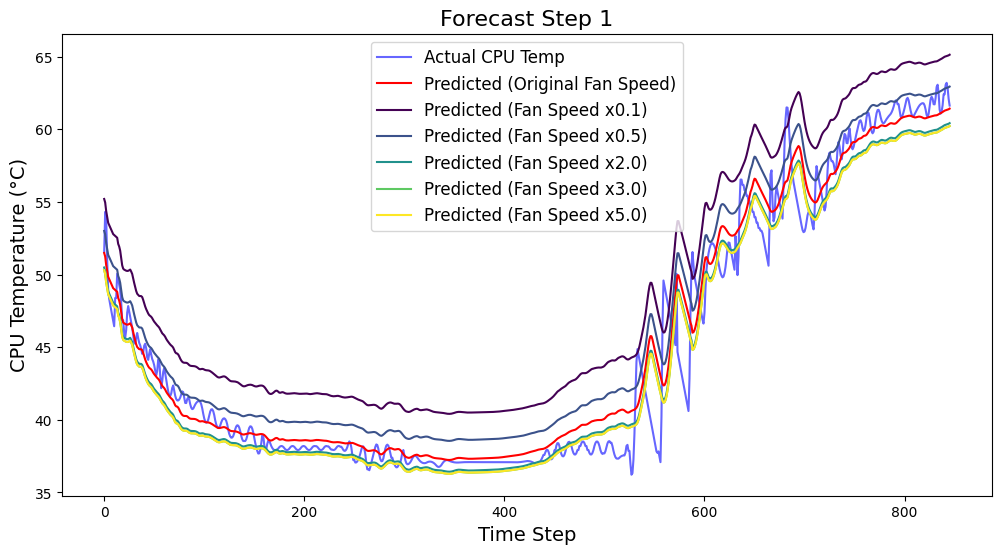

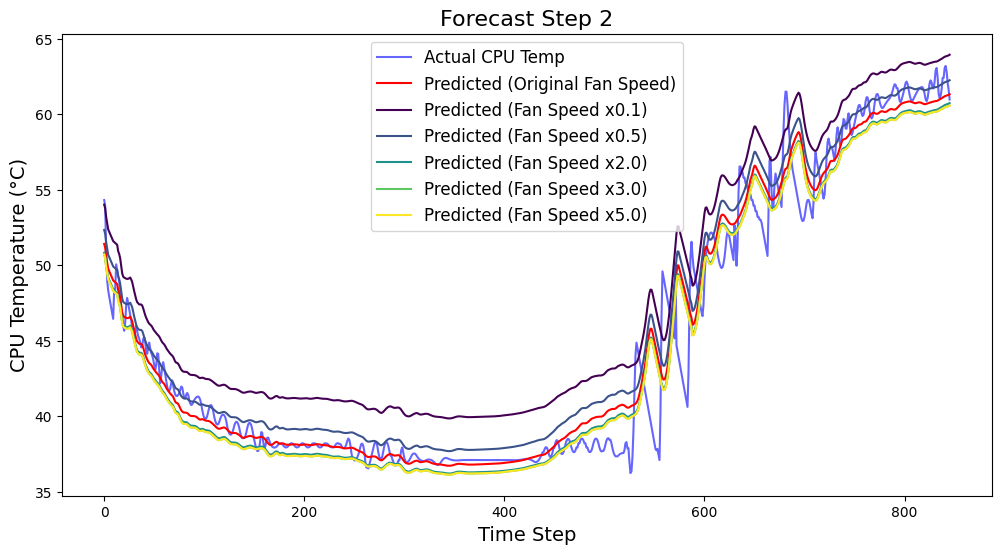

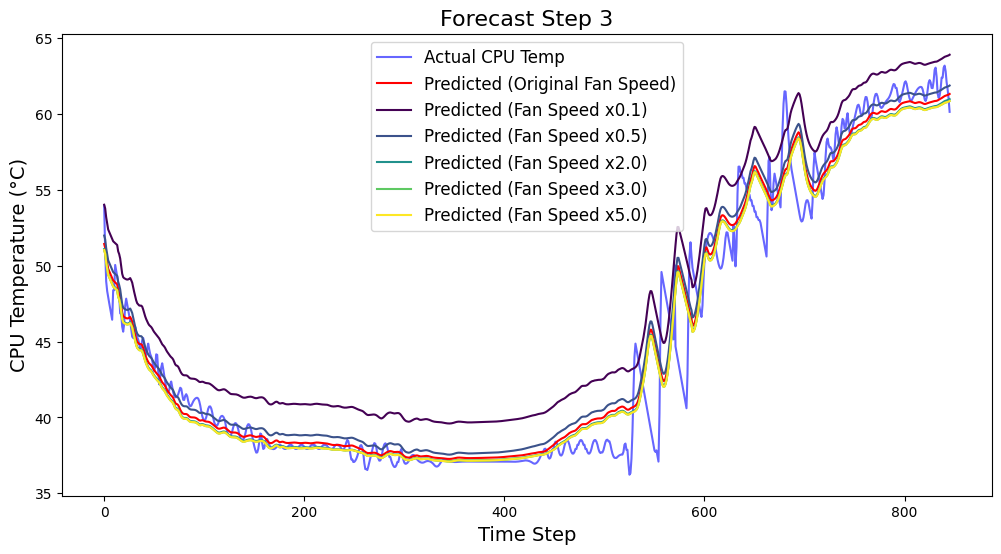

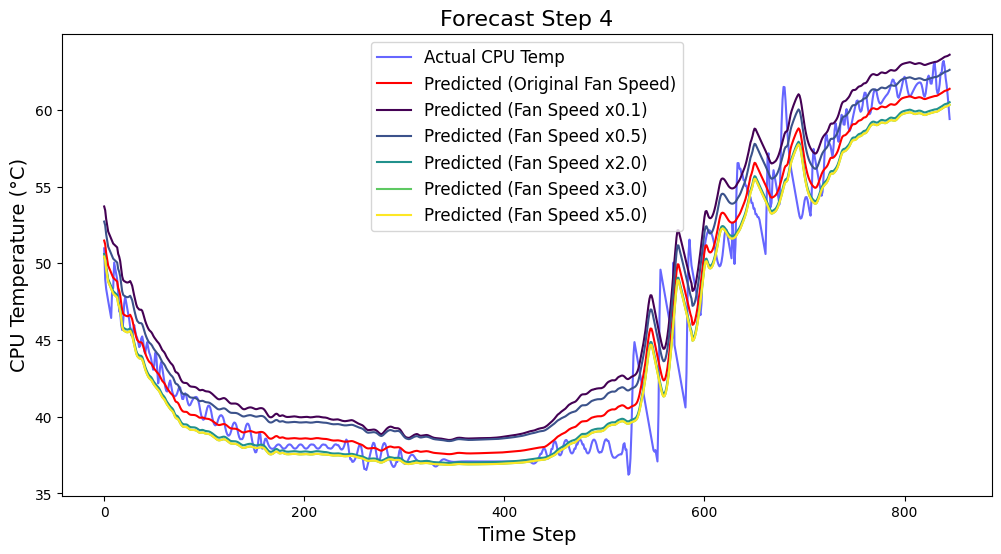

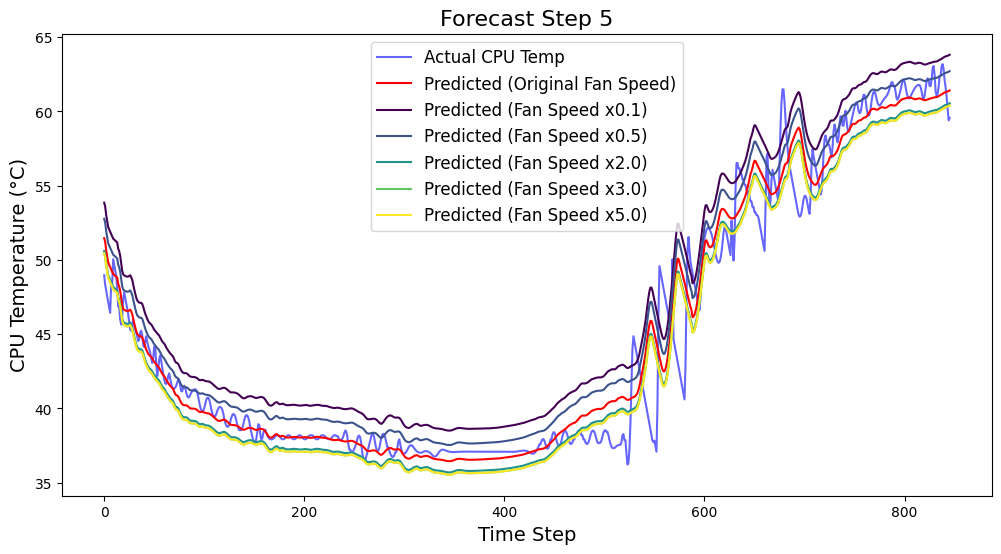

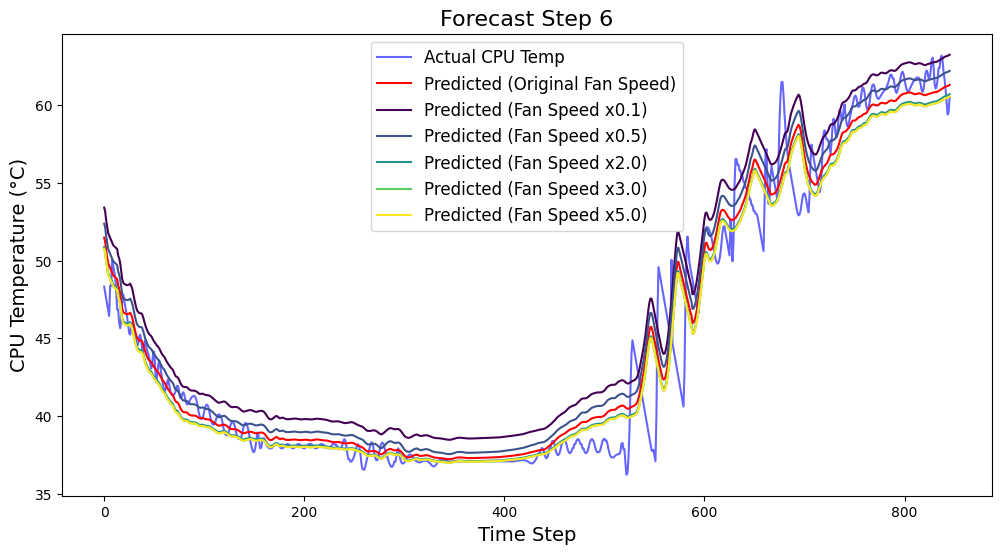

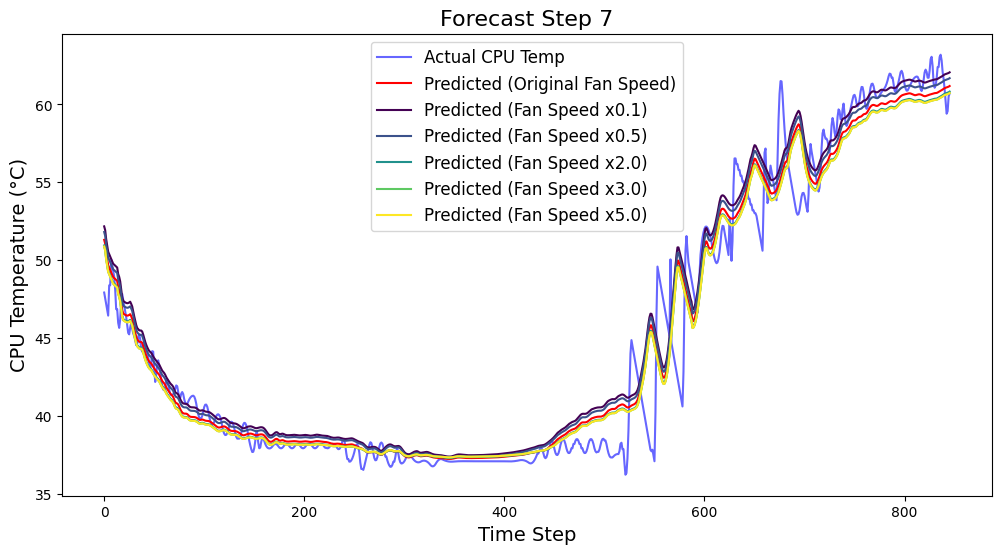

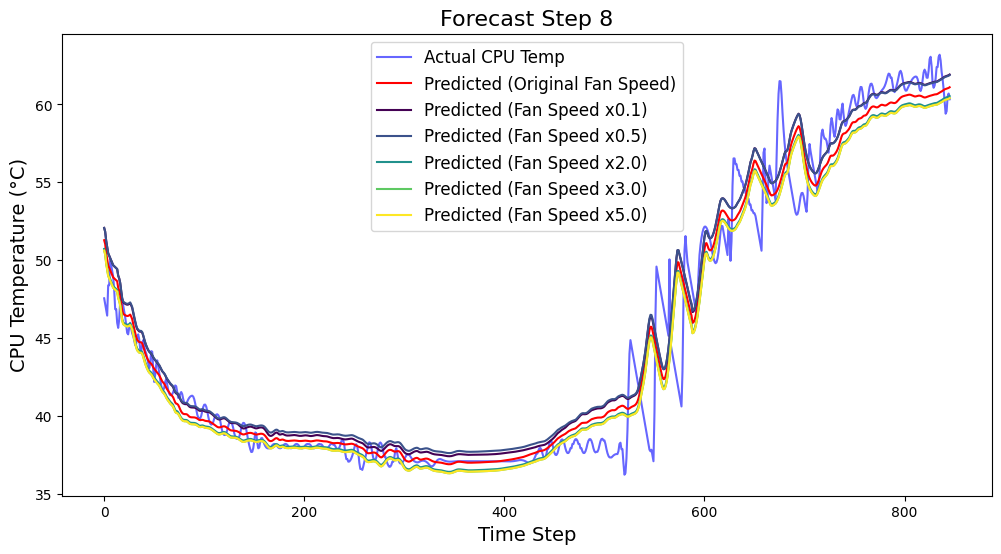

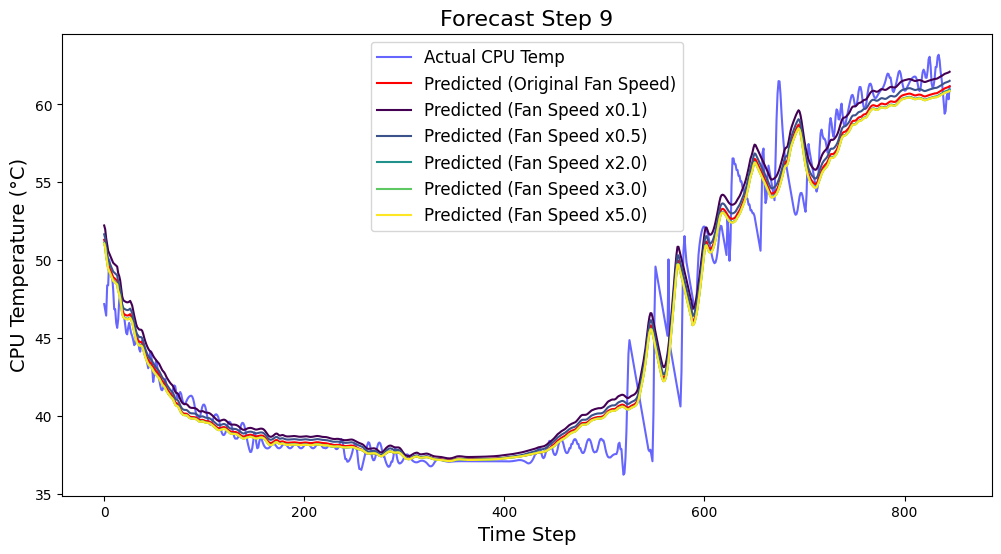

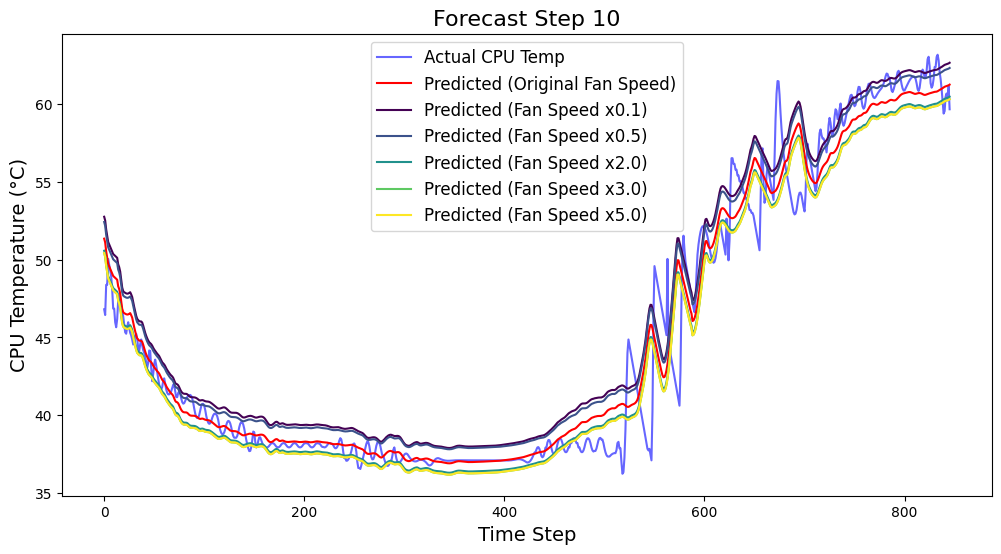

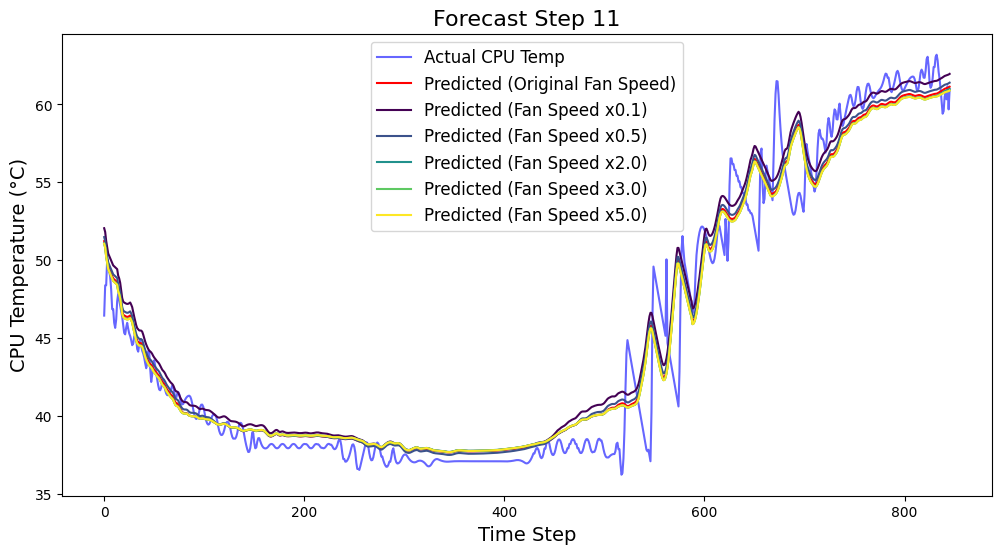

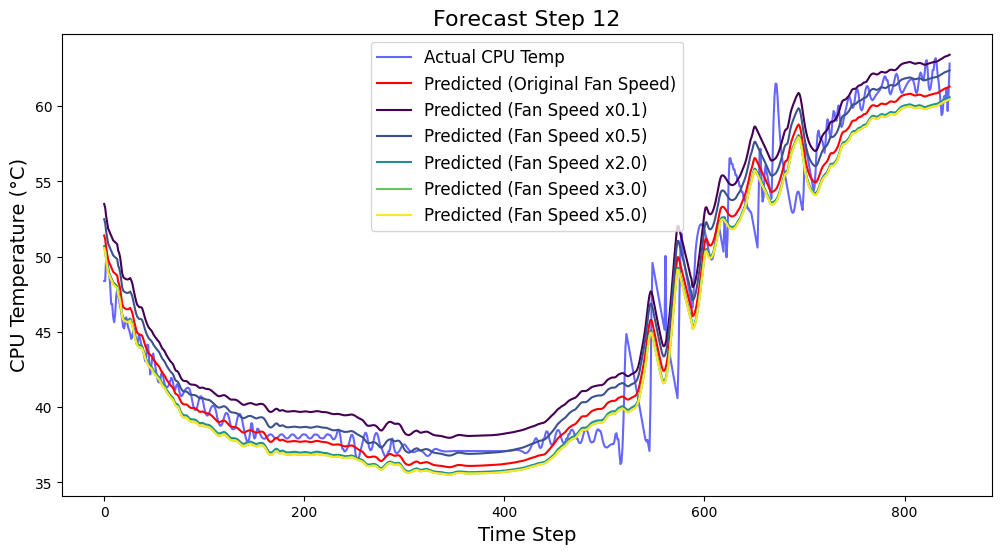

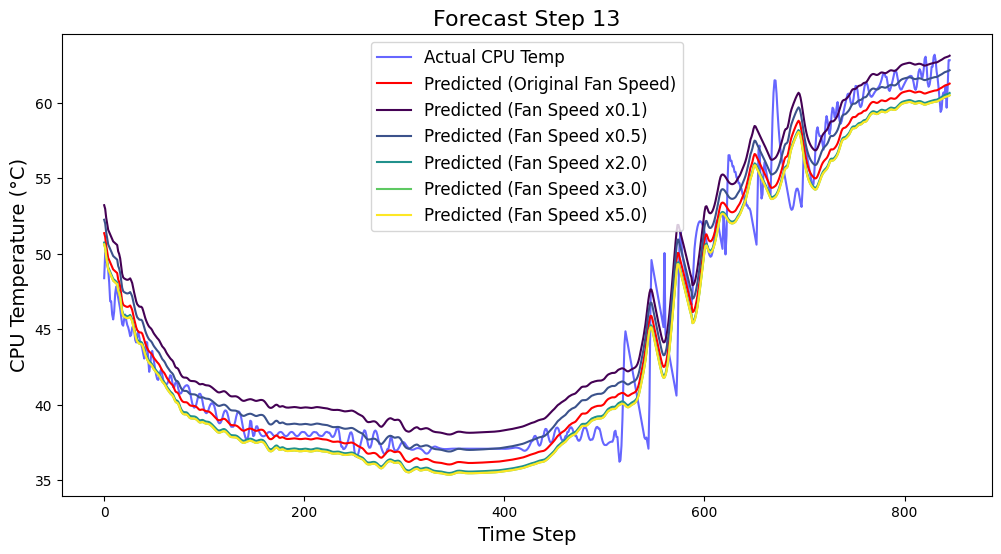

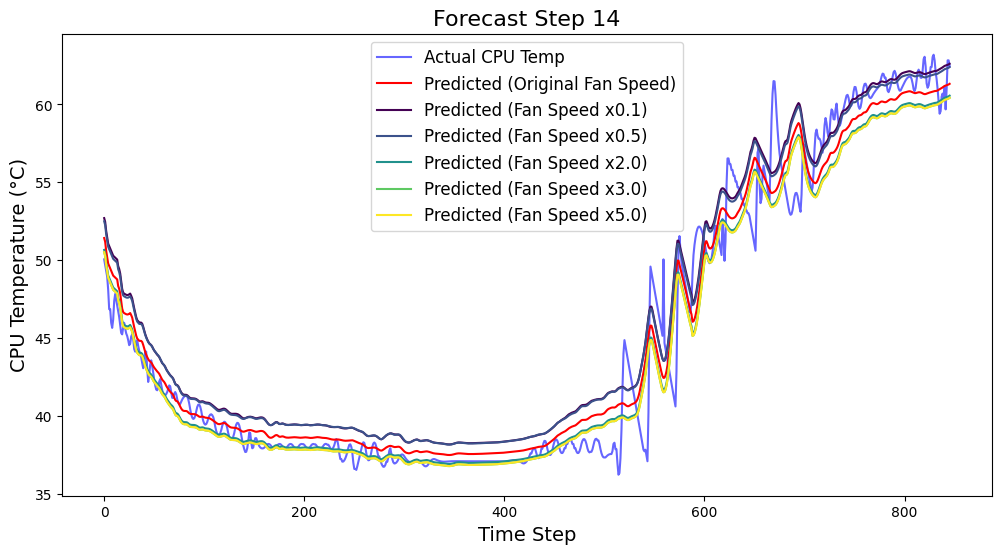

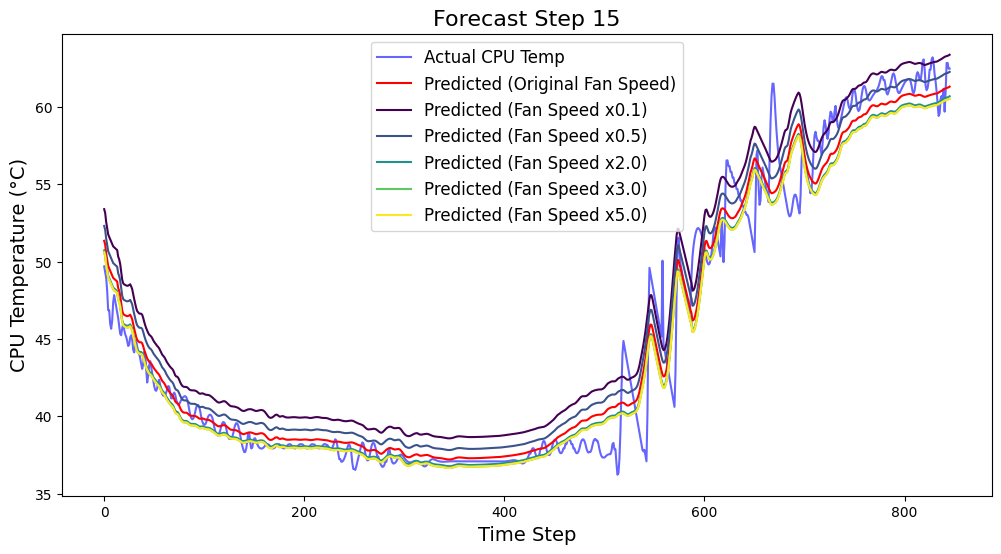

: 

In [ ]:
modified_fan_speeds = [0.1, 0.5, 2.0, 3.0, 5.0]

actual_preds_dict, modified_preds_dict, actuals = demo_modified_fan_loop(model, test_loader, scalers["cpu_temp"], k_step, modified_fan_speeds)
plot_forecasts_loop(actual_preds_dict, modified_preds_dict, actuals, k_step, modified_fan_speeds)